# Load Line P bottle samples
Author: Hayley Dosser

Created: October, 2025

Bottle samples that were collected as part of the DFO Line P cruise program, then corrected and distributed by Franco et al., 2021 as part of their publication "Anthropogenic and Climatic Contributions to Observed Carbon System Trends in the Northeast Pacific" (DOI: 10.1029/2020GB006829). Some simple pre-processing has been applied, and output is written to a new CSV file for use in the SD-Ocean Line P Hackathon (December 2025). 

In [52]:
import gsw
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

%matplotlib notebook
%matplotlib inline


# User-specified path

In [53]:
path = 'C:/Users/DosserH/Documents/S2D/Statistical downscaling/HackathonLineP/'

# Load dataset into a Pandas dataframe

In [54]:
df = pd.read_csv(f'{path}/LineP_for_Data_Synthesis_1990-2019_v1.csv',delimiter=',', usecols=np.arange(0,33).tolist())

In [55]:
df

,EXPOCODE,CRUISE_ID,STATION_ID,EVENT_NO,NISKIN_NO,YEAR_UTC,MONTH_UTC,DAY_UTC,TIME_UTC,YEARDAY_UTC,...,DIC_FLAG_W,TA_UMOL_KG,TA_FLAG_W,NITRATE_NITRITE_UMOL_KG,NITRATE_NITRITE_FLAG_W,SILICATE_UMOL_KG,SILICATE_FLAG_W,PHOSPHATE_UMOL_KG,PHOSPHATE_FLAG_W,original_filename
0,18PZ19900509,1990.01,4,1,-999,1990,5,10,21:14,130,...,2,-999.0,9,0.0,2,3.5,2,0.29,2,1990-001-0001.bot
1,18PZ19900509,1990.01,4,1,-999,1990,5,10,21:14,130,...,2,-999.0,9,0.0,2,2.5,2,0.21,2,1990-001-0001.bot
2,18PZ19900509,1990.01,4,1,-999,1990,5,10,21:14,130,...,2,-999.0,9,0.0,2,3.0,2,0.22,2,1990-001-0001.bot
3,18PZ19900509,1990.01,4,1,-999,1990,5,10,21:14,130,...,2,-999.0,9,13.4,2,17.4,2,1.25,2,1990-001-0001.bot
4,18PZ19900509,1990.01,4,1,-999,1990,5,10,21:14,130,...,2,-999.0,9,11.2,2,13.2,2,1.10,2,1990-001-0001.bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978,18DD20190602,2019.06,26,77,5,2019,6,10,17:44,161,...,2,2414.7,2,40.3,2,167.5,3,2.86,2,2019-006-0077.che
4979,18DD20190602,2019.06,26,77,4,2019,6,10,17:44,161,...,2,2411.2,2,38.8,2,164.8,3,2.73,2,2019-006-0077.che
4980,18DD20190602,2019.06,26,77,3,2019,6,10,17:44,161,...,2,2412.3,2,37.7,2,163.9,3,2.63,2,2019-006-0077.che
4981,18DD20190602,2019.06,26,77,2,2019,6,10,17:44,161,...,6,2417.8,6,37.1,2,162.6,3,2.60,2,2019-006-0077.che


## Pre-processing
Apply quality flags, replace -999 with NaN, combine data records from early and late parts of the time series for temperature, salinity, and depth

In [56]:
# Create a new combined time variable
df['TIME'] = [f"{row.YEAR_UTC}-{row.MONTH_UTC}-{row.DAY_UTC}-{row.TIME_UTC}" for _, row in df.iterrows()]

In [63]:
# Create new latitude and longitude variables
fld = df.LATITUDE_DEC.copy()
df['LATITUDE'] = fld.replace(-999,np.nan)

fld = df.LONGITUDE_DEC.copy()
df['LONGITUDE'] = fld.replace(-999,np.nan)

# Create depth variable and pressure variable by combining depth from early records with pressure converted to depth from CTD profile records
fld = -gsw.z_from_p(df.CTDPRS_DBAR, df.LATITUDE_DEC)
fld[df.CTDPRS_DBAR==-999] = df.DEPTH_METER[df.CTDPRS_DBAR==-999]
df['DEPTH'] = fld.replace(-999,np.nan)

df['PRESSURE'] = gsw.p_from_z(-df.DEPTH, df.LATITUDE_DEC)

# Create temperature variables by combining reversing thermometer records early in the time series and CTD profiles later in the time series
fld = df.CTDTMP_ITS90_DEG_C.copy()
fld.loc[df.CTDTMP_ITS90_DEG_C==-999] = df.TMP_REVERSING_DEG_C.loc[df.CTDTMP_ITS90_DEG_C==-999]
df['TEMPERATURE'] = fld.replace(-999,np.nan)

#Create salinity variable by combining salinity from bottle samples early in the time series with CTD profiles later in the time series
fld = df.CTDSAL_PSS78.copy()
fld.loc[df.CTDSAL_PSS78==-999] = df.SALINITY_PSS78.loc[df.CTDSAL_PSS78==-999]
fld_flg = df.CTDSAL_FLAG_W.copy()
fld_flg.loc[df.CTDSAL_PSS78==-999] = df.SALINITY_FLAG_W[df.CTDSAL_PSS78==-999]
fld.loc[fld_flg!=2] = -999
df['SALINITY'] = fld.replace(-999,np.nan)

#Create BGC variables, apply quality flags
fld = df.OXYGEN_UMOL_KG.copy()
flg = df.OXYGEN_FLAG_W!=2
fld[flg] = -999
df['OXYGEN'] = fld.replace(-999,np.nan)

fld = df.DIC_UMOL_KG.copy()
flg = df.DIC_FLAG_W!=2
fld[flg] = -999
df['DIC'] = fld.replace(-999,np.nan)

fld = df.TA_UMOL_KG.copy()
flg = df.TA_FLAG_W!=2
fld[flg] = -999
df['TA'] = fld.replace(-999,np.nan)

fld = df.NITRATE_NITRITE_UMOL_KG.copy()
flg = df.NITRATE_NITRITE_FLAG_W!=2
fld[flg] = -999
df['NITRATE'] = fld.replace(-999,np.nan)

fld = df.PHOSPHATE_UMOL_KG.copy()
flg = df.PHOSPHATE_FLAG_W!=2
fld[flg] = -999
df['PHOSPHATE'] = fld.replace(-999,np.nan)

fld = df.SILICATE_UMOL_KG.copy()
flg = df.SILICATE_FLAG_W!=2
fld[flg] = -999
df['SILICATE'] = fld.replace(-999,np.nan)

In [58]:
list(df)

['EXPOCODE',
 'CRUISE_ID',
 'STATION_ID',
 'EVENT_NO',
 'NISKIN_NO',
 'YEAR_UTC',
 'MONTH_UTC',
 'DAY_UTC',
 'TIME_UTC',
 'YEARDAY_UTC',
 'LONGITUDE_DEC',
 'LATITUDE_DEC',
 'CTDPRS_DBAR',
 'DEPTH_METER',
 'CTDTMP_ITS90_DEG_C',
 'TMP_REVERSING_DEG_C',
 'CTDSAL_PSS78',
 'CTDSAL_FLAG_W',
 'SALINITY_PSS78',
 'SALINITY_FLAG_W',
 'OXYGEN_UMOL_KG',
 'OXYGEN_FLAG_W',
 'DIC_UMOL_KG',
 'DIC_FLAG_W',
 'TA_UMOL_KG',
 'TA_FLAG_W',
 'NITRATE_NITRITE_UMOL_KG',
 'NITRATE_NITRITE_FLAG_W',
 'SILICATE_UMOL_KG',
 'SILICATE_FLAG_W',
 'PHOSPHATE_UMOL_KG',
 'PHOSPHATE_FLAG_W',
 'original_filename',
 'TIME',
 'LATITUDE',
 'LONGITUDE',
 'DEPTH',
 'PRESSURE',
 'TEMPERATURE',
 'SALINITY',
 'OXYGEN',
 'DIC',
 'TA',
 'NITRATE',
 'PHOSPHATE',
 'SILICATE']

### Quick look at the distribution for each variable

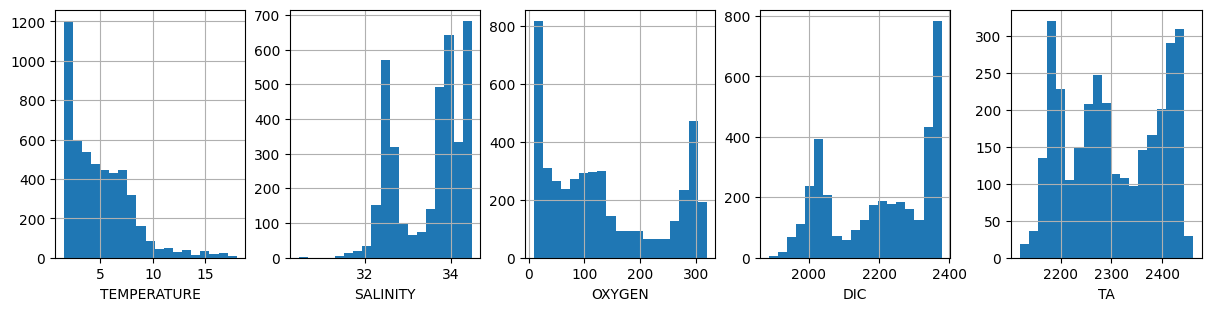

In [59]:
var_list = ['TEMPERATURE','SALINITY','OXYGEN','DIC','TA']
fig, ax = plt.subplots(1, ncols=5, constrained_layout=True, figsize=(12, 3))

for n, var in enumerate(var_list):
    fld = df[var].values   

    bins = np.arange(np.nanmin(fld),np.nanmax(fld),(np.nanmax(fld)-np.nanmin(fld))/20)
    ax[n].hist(fld,bins,alpha=1)
    ax[n].set_xlabel(var)
    ax[n].grid()

## Write pre-processed data to CSV

In [ ]:
# Text for the CSV file header
header_text = """
# Description: Bottle samples collected as part of the DFO Line P cruise program 
# then corrected and distributed by Franco et al. 2021 (DOI: 10.1029/2020GB006829) 
# then pre-processed for the SD-Ocean Line P Hackathon in October 2025. 
# Temperature was measured by reversing therometer early in the record and salinity via bottle sample. 
# Temperature and salinity in the later part of the record are from CTD profiles. 
# Oxygen and DIC and TA and the nutrients are from bottle samples of seawater.  
# 
# Collection:
# CRUISE_ID label
#
# Coordinates:
# STATION_ID for Line P stations P4 to P26
# TIME in UTC between 1990 to 2019 
# LATITUDE in decimal degrees
# LONGITUDE in decimal degrees
# DEPTH in m
# PRESSURE in dbar
# 
# Variables: 
# TEMPERATURE in degrees Celcius (in-situ)
# SALINITY PSS-78
# OXYGEN in µmol/kg (dissolved oxygen)
# DIC in µmol/kg
# TA in µmol/kg
# NITRATE in µmol/kg (nitrate plus nitrite)
# PHOSPHATE in µmol/kg
# SILICATE in µmol/kg

"""

In [75]:
# Write the variables to CSV
variable_list = [
    'STATION_ID',
    'TIME',
    'LATITUDE',
    'LONGITUDE',
    'DEPTH',
    'PRESSURE',
    'TEMPERATURE',
    'SALINITY',
    'OXYGEN',
    'DIC',
    'TA',
    'NITRATE',
    'PHOSPHATE',
    'SILICATE'
]

with open("DFO_LineP_bottles.csv","w") as f:
    f.write(header_text)
    df[variable_list].to_csv(f,index=False,na_rep="NaN")